Checking disk space...
Filesystem      Size  Used Avail Use% Mounted on
/dev/loop1       20G  2.6G   17G  14% /kaggle/working
Num GPUs Available:  0
✅ File loaded successfully!
📊 Label counts:
 label
benign       8061
malignant    1954
Name: count, dtype: int64
✅ Total images copied to ./all_images/: 10015
✅ Linked image paths to DataFrame
✅ Training set: 8012 images
✅ Validation set: 2003 images
Found 8012 validated image filenames belonging to 2 classes.
Found 2003 validated image filenames belonging to 2 classes.
Found 2003 validated image filenames belonging to 2 classes.

Training ResNet50 model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 1027s 4s/step - accuracy: 0.7976 - loss: 0.4630 - val_accuracy: 0.8357 - val_loss: 0.3424
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 1004s 4s/step - accuracy: 0.8368 - loss: 0.3550 - val_accuracy: 0.8347 - val_loss: 0.3419
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 1013s 4s/step - accuracy: 0.8445 - loss: 0.3299 - val_accuracy: 0.8387 - val_loss: 0.3331
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 974s 4s/step - accuracy: 0.8548 - loss: 0.3237 - val_accuracy: 0.8427 - val_loss: 0.3264
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 994s 4s/step - accuracy: 0.8529 - loss: 0.3175 - val_accuracy: 0.8497 - val_loss: 0.3249
✅ ResNet50 model saved to ./saved_models/resnet50_skin_cancer.h5

Training MobileNetV2 model...
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.7996 - loss: 0.4996 - val_accuracy: 0.8347 - val_loss: 0.3634
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.8398 - loss: 0.3555 - val_accuracy: 0.8293 - val_loss: 0.3553
Epoch

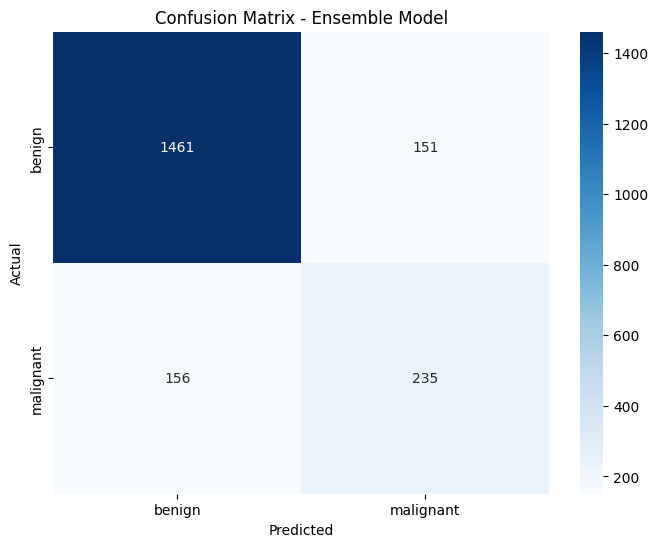

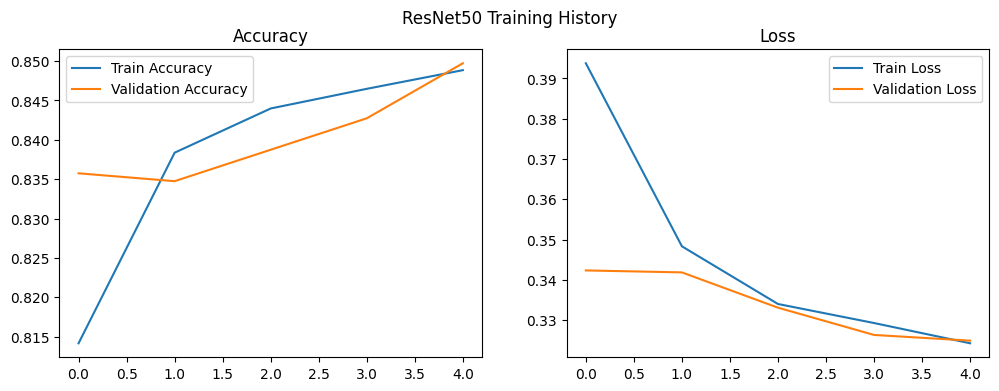

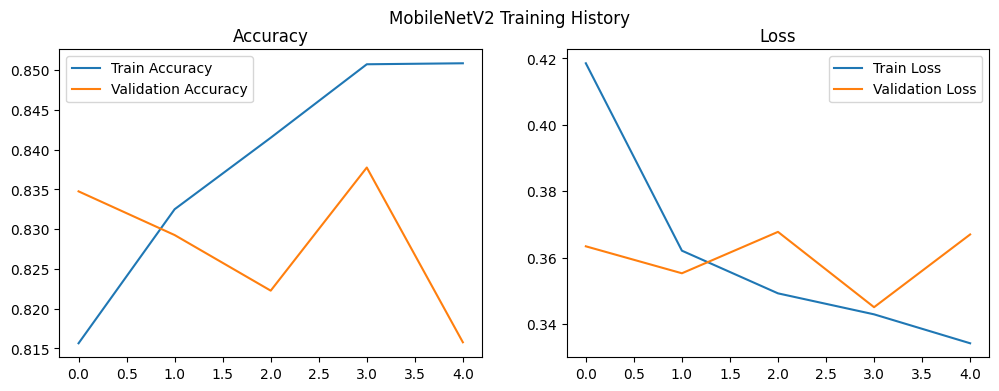

  adding: kaggle/working/saved_models/ (stored 0%)
  adding: kaggle/working/saved_models/resnet_training_history.png (deflated 9%)
  adding: kaggle/working/saved_models/confusion_matrix.png (deflated 18%)
  adding: kaggle/working/saved_models/mobilenetv2_skin_cancer.h5 (deflated 11%)
  adding: kaggle/working/saved_models/resnet50_metrics.json (deflated 27%)
  adding: kaggle/working/saved_models/ensemble_metrics.json (deflated 28%)
  adding: kaggle/working/saved_models/resnet50_skin_cancer.h5 (deflated 8%)
  adding: kaggle/working/saved_models/ensemble_skin_cancer.pkl (deflated 8%)
  adding: kaggle/working/saved_models/mobilenet_training_history.png (deflated 8%)
  adding: kaggle/working/saved_models/mobilenetv2_metrics.json (deflated 27%)
  adding: kaggle/working/saved_models/class_indices.json (deflated 3%)

✅ All models and evaluation metrics saved successfully!
📁 You can download the models from the output section or using the following commands:
   - resnet50_skin_cancer.h5: ResNet

In [3]:
# skin_cancer_classification.py
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

# Constants
IMG_SIZE = 224
COMBINED_DIR = "./all_images/"
MODEL_SAVE_DIR = "./saved_models/"
os.makedirs(COMBINED_DIR, exist_ok=True)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Check disk space
print("Checking disk space...")
!df -h /kaggle/working

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load and prepare the metadata
file_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    df['label'] = df['dx'].apply(lambda x: 'malignant' if x in ['mel', 'bcc', 'akiec'] else 'benign')
    print("✅ File loaded successfully!")
    print("📊 Label counts:\n", df['label'].value_counts())
else:
    print(f"File {file_path} not found. Please ensure the HAM10000 dataset is attached.")
    raise FileNotFoundError(f"File {file_path} not found.")

# Combine all images into one directory
image_dirs = [
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
]

# Copy all images to combined directory
for image_dir in image_dirs:
    image_paths = glob(os.path.join(image_dir, '*.jpg'))
    for path in image_paths:
        shutil.copy(path, COMBINED_DIR)

print(f"✅ Total images copied to {COMBINED_DIR}: {len(os.listdir(COMBINED_DIR))}")

# Link image paths to DataFrame
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(COMBINED_DIR, x + '.jpg'))
df = df[df['image_path'].apply(os.path.exists)]  # Ensure images exist
print("✅ Linked image paths to DataFrame")

# Split data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(f"✅ Training set: {len(train_df)} images")
print(f"✅ Validation set: {len(val_df)} images")

# Create data generators with preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Save class indices
class_indices = train_generator.class_indices
with open(os.path.join(MODEL_SAVE_DIR, 'class_indices.json'), 'w') as f:
    json.dump(class_indices, f)

# Model building function
def build_model(base_model_fn, preprocess_fn, weights_path=None):
    if weights_path and not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights file {weights_path} not found. Please upload it to Kaggle.")
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_fn(inputs)
    base_model = base_model_fn(include_top=False, weights=weights_path, input_tensor=x)
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Paths to offline weights
RESNET_WEIGHTS_PATH = '/kaggle/input/the-wight/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
MOBILENET_WEIGHTS_PATH = '/kaggle/input/the-wight/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

# Build and train ResNet50 model
print("\nTraining ResNet50 model...")
try:
    resnet_model = build_model(ResNet50, resnet_preprocess, weights_path=RESNET_WEIGHTS_PATH)
    resnet_history = resnet_model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        verbose=1
    )
    
    # Save ResNet50 model
    resnet_save_path = os.path.join(MODEL_SAVE_DIR, 'resnet50_skin_cancer.h5')
    resnet_model.save(resnet_save_path)
    print(f"✅ ResNet50 model saved to {resnet_save_path}")
except Exception as e:
    print(f"Error training ResNet50: {e}")
    raise

# Build and train MobileNetV2 model
print("\nTraining MobileNetV2 model...")
try:
    mobilenet_model = build_model(MobileNetV2, mobilenet_preprocess, weights_path=MOBILENET_WEIGHTS_PATH)
    mobilenet_history = mobilenet_model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        verbose=1
    )
    
    # Save MobileNetV2 model
    mobilenet_save_path = os.path.join(MODEL_SAVE_DIR, 'mobilenetv2_skin_cancer.h5')
    mobilenet_model.save(mobilenet_save_path)
    print(f"✅ MobileNetV2 model saved to {mobilenet_save_path}")
except Exception as e:
    print(f"Error training MobileNetV2: {e}")
    raise

# Evaluate models
def evaluate_model(model, generator, model_name):
    y_pred = model.predict(generator)
    y_pred_classes = (y_pred > 0.5).astype(int)
    y_true = generator.labels
    
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes)
    roc_auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred_classes)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm.tolist()
    }
    
    # Save metrics
    with open(os.path.join(MODEL_SAVE_DIR, f'{model_name}_metrics.json'), 'w') as f:
        json.dump(metrics, f)
    
    return metrics

print("\nEvaluating models...")
resnet_metrics = evaluate_model(resnet_model, test_generator, 'resnet50')
mobilenet_metrics = evaluate_model(mobilenet_model, test_generator, 'mobilenetv2')

# Create and evaluate ensemble
class AveragingEnsemble:
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2
    
    def predict(self, x):
        pred1 = self.model1.predict(x)
        pred2 = self.model2.predict(x)
        return (pred1 + pred2) / 2

ensemble_model = AveragingEnsemble(resnet_model, mobilenet_model)
ensemble_save_path = os.path.join(MODEL_SAVE_DIR, 'ensemble_skin_cancer.pkl')
import pickle
with open(ensemble_save_path, 'wb') as f:
    pickle.dump(ensemble_model, f)
print(f"✅ Ensemble model saved to {ensemble_save_path}")

# Evaluate ensemble
ensemble_metrics = evaluate_model(ensemble_model, test_generator, 'ensemble')

# Print all metrics
def print_metrics(metrics, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print("Confusion Matrix:")
    print(np.array(metrics['confusion_matrix']))

print_metrics(resnet_metrics, "ResNet50")
print_metrics(mobilenet_metrics, "MobileNetV2")
print_metrics(ensemble_metrics, "Ensemble")

# Plot confusion matrix for ensemble
plt.figure(figsize=(8, 6))
sns.heatmap(np.array(ensemble_metrics['confusion_matrix']), annot=True, fmt='d', cmap="Blues", 
            xticklabels=["benign", "malignant"], 
            yticklabels=["benign", "malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ensemble Model")
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'confusion_matrix.png'))
plt.show()

# Plot training history
def plot_history(history, title, filename):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    
    plt.savefig(os.path.join(MODEL_SAVE_DIR, filename))
    plt.show()

plot_history(resnet_history, "ResNet50 Training History", "resnet_training_history.png")
plot_history(mobilenet_history, "MobileNetV2 Training History", "mobilenet_training_history.png")

# Create a zip file of the saved models for easy download
!zip -r /kaggle/working/skin_cancer_models.zip /kaggle/working/saved_models

print("\n✅ All models and evaluation metrics saved successfully!")
print("📁 You can download the models from the output section or using the following commands:")
print("   - resnet50_skin_cancer.h5: ResNet50 model")
print("   - mobilenetv2_skin_cancer.h5: MobileNetV2 model")
print("   - ensemble_skin_cancer.pkl: Ensemble model")
print("   - skin_cancer_models.zip: All models in a zip file")